In [1]:
import os, random, glob
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')
K.set_floatx("float32")

Using TensorFlow backend.


In [2]:
#from skimage.data import imread
#from skimage.io import imshow,imsave
#from skimage import img_as_float
import cv2
#from skimage.util import crop
#from skimage.transform import rotate
#from skimage.transform import resize
import math

In [3]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
modelStr = 'Crop'
ROWS = 224
COLS = 224
BatchSize = 64
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [4]:
#Loading data

import pickle

if os.path.exists('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist images_annotations_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        images_annotations = pickle.load(f)
    images = images_annotations['images']
    annotations = images_annotations['annotations']
else:
    print ('Loading data from original images. Generating images_annotations_{}_{}.pickle.'.format(ROWS, COLS))
    
    images = []
    annotations = []

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')
    crop_classes

    for c in crop_classes:
        labels = pd.read_json('../data/annotation/'+c.lower()+'_labels.json')
        for i in range(len(labels)):
            try:
                img_filename = labels.iloc[i,2]
                print(img_filename)
                l1 = pd.DataFrame((labels[labels.filename==img_filename].annotations).iloc[0])
                im = Image.open(TRAIN_DIR+c+'/'+img_filename)
                im_resized = im.resize((COLS, ROWS), Image.BILINEAR)
                w, h = im.size
                x_ratio = float(COLS)/w
                y_ratio = float(ROWS)/h
                annotations.append([l1.iloc[0,1]*x_ratio,
                                    l1.iloc[0,2]*y_ratio,
                                    l1.iloc[1,1]*x_ratio,
                                    l1.iloc[1,2]*y_ratio])
                images.append(np.asarray(im_resized))
                print('success')
            except:
                print('fail')
    
    images = np.asarray(images, dtype=np.uint8)
    annotations = np.asarray(annotations)
    #save data to file
    images_annotations = {'images': images,'annotations': annotations }

    with open('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(images_annotations, f)
        

Exist images_annotations_224_224.pickle. Loading data from file.


In [5]:
#生成图像随机变换矩阵
#modified from code https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

def transform_matrix_offset_center(matrix, w, h):
    center_x = float(w) / 2 + 0.5
    center_y = float(h) / 2 + 0.5
    #图像center移到原点，进行rotation和shear
    offset_matrix = np.array([[1, 0, center_x], [0, 1, center_y], [0, 0, 1]])
    #移回来
    reset_matrix = np.array([[1, 0, -center_x], [0, 1, -center_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(reset_matrix, matrix), offset_matrix)
    return transform_matrix

def random_transform_matrix(image,
                            rotation_range=0.,
                            width_shift_range=0.,
                            height_shift_range=0.,
                            shear_range=0.,
                            zoom_range=0.,
                            horizontal_flip=False,
                            vertical_flip=False):
    
    h, w = image.shape[0], image.shape[1]
       
    #图像上下翻转
    hflip_matrix=np.eye(3)
    if horizontal_flip:
        if np.random.random() < 0.5:
            #print("horizontal_flip")
            hflip_matrix = np.array([[-1, 0, w],
                                     [0, 1, 0],
                                     [0, 0, 1]])
    #图像左右翻转                              
    vflip_matrix=np.eye(3)
    if vertical_flip:
        if np.random.random() < 0.5:
            #print("vertical_flip")
            vflip_matrix = np.array([[1, 0, 0],
                                     [0, -1, h],
                                     [0, 0, 1]])
    #图像顺时针旋转theta       
    if rotation_range:
        theta = np.pi / 180 * np.random.uniform(-rotation_range, rotation_range)
    else:
        theta = 0
    #print("theta =",theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    
    #图像往正轴移动tx，ty
    if height_shift_range:
        ty = np.random.uniform(-height_shift_range, height_shift_range) * h
    else:
        ty = 0

    if width_shift_range:
        tx = np.random.uniform(-width_shift_range, width_shift_range) * w
    else:
        tx = 0
    #print("tx =",tx)
    #print("ty =",ty)
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    
    #图像顺时针shear
    if shear_range:
        shear = np.random.uniform(-shear_range, shear_range)
    else:
        shear = 0
    #print("shear =",shear)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    
    #以center为中心图像放大zx，zy
    if np.isscalar(zoom_range):
        zoom_range = [1 - zoom_range, 1 + zoom_range]
    elif len(zoom_range) == 2:
        zoom_range = [zoom_range[0], zoom_range[1]]
    else:
        raise ValueError('zoom_range should be a float or '
                         'a tuple or list of two floats. '
                         'Received arg: ', zoom_range)
            
    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    #print("zx =",zx)
    #print("zy =",zy)
    zoom_matrix = np.array([[zx, 0, (1-zx)*w/2.],
                            [0, zy, (1-zy)*h/2.],
                            [0, 0, 1]])
    #transform_matrix = zoom_matrix
    transform_matrix = np.dot(shear_matrix, rotation_matrix)
    transform_matrix = transform_matrix_offset_center(transform_matrix, w, h)
    transform_matrix = np.dot(np.dot(np.dot(np.dot(translation_matrix, 
                                                   zoom_matrix), 
                                            transform_matrix), 
                                     vflip_matrix), 
                              hflip_matrix)
    return transform_matrix[:2,:]

In [6]:
history = []

def model_train(model, images, annotations, nb_batch = 1000):
    import queue

    q_images = queue.Queue()
    q_annotations = queue.Queue()

    for i in range(nb_batch):
        print('Batch ',i)
        count = 0
        x_batch = np.ndarray((BatchSize, ROWS, COLS, 3), dtype=np.float32)
        y_batch = np.ndarray((BatchSize, 4), dtype=np.float32)
        while count<BatchSize:
            print('count ',count)
            if q_images.empty():

                #shuffle epoch
                epoch_size = len(images)
                index = np.random.permutation(epoch_size)
                images = images[index,:,:,:]
                annotations = annotations[index,:]

                for i in range(epoch_size):
                    q_images.put(images[i])
                    q_annotations.put(annotations[i])
            else:
                image = q_images.get()
                annotation = q_annotations.get()
                rescale = 1./255,
                image = image*rescale
                M = random_transform_matrix(image,
                                            rotation_range=20,
                                            shear_range=0.2,
                                            zoom_range=0.1,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=True,
                                            vertical_flip=True)
                h, w = image.shape[0], image.shape[1]
                image_transformed = cv2.warpAffine(image, M, (w, h), borderMode=0)
                head_transformed = np.dot(M,np.array([annotation[0],annotation[1],1]))
                tail_transformed = np.dot(M,np.array([annotation[2],annotation[3],1]))
                if 0<=head_transformed[0]<=w and 0<=head_transformed[1]<=h and \
                0<=tail_transformed[0]<=w and 0<=tail_transformed[1]<=h:
                    x_batch[count] = image_transformed
                    y_batch[count] = [head_transformed[0],head_transformed[1],tail_transformed[0],tail_transformed[1]]
                    count += 1
        history.append(model.train_on_batch(x_batch, y_batch))       
        print(history[-1])


In [7]:
#stg1 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(4, init='glorot_normal', activation='linear')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# train the model on the new data for a few epochs
model_train(model, images, annotations, nb_batch=2)

Batch  0
count  0
count  0
count  1
count  2
count  3
count  4
count  5
count  6
count  7
count  8
count  8
count  8
count  9
count  10
count  11
count  12
count  12
count  13
count  14
count  15
count  15
count  16
count  17
count  18
count  19
count  20
count  21
count  22
count  23
count  23
count  24
count  25
count  25
count  25
count  26
count  26
count  27
count  27
count  28
count  29
count  30
count  30
count  31
count  32
count  32
count  33
count  34
count  35
count  36
count  37
count  38
count  39
count  40
count  40
count  40
count  41
count  42
count  43
count  44
count  45
count  46
count  47
count  47
count  48
count  48
count  48
count  49
count  49
count  50
count  50
count  50
count  51
count  51
count  52
count  53
count  53
count  53
count  53
count  54
count  55
count  56
count  57
count  57
count  57
count  58
count  59
count  60
count  60
count  61
count  62
count  63
count  63
13333.2
Batch  1
count  0
count  1
count  2
count  3
count  3
count  4
count  5
coun

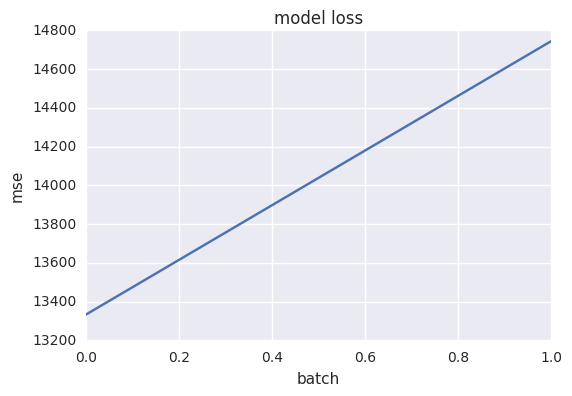

In [8]:
plt.plot(history); 
plt.title('model loss'); plt.ylabel('mse'); plt.xlabel('batch');
plt.show()

In [9]:
model.evaluate(self, x_valid, y_valid, batch_size=BatchSize, verbose=1, sample_weight=None)

['loss']

In [ ]:
#stg2 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:14]:
   layer.trainable = False
for layer in model.layers[14:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#test submission

import datetime

if os.path.exists('../data/data_test_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test = data_test['X_test']
    test_files = data_test['test_files']
else:
    print ('Loading test data from original images. Generating data_test_{}_{}.pickle.'.format(ROWS, COLS))

    test_files = [im for im in os.listdir(TEST_DIR)]
    X_test = np.ndarray((len(test_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_files): 
        X_test[i] = read_image(TEST_DIR+im)
        if i%300 == 0: print('Processed {} of {}'.format(i, len(test_files)))
            
    data_test = {'X_test': X_test,'test_files': test_files }
    
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f)
            
X_test = X_test / 255.

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
model = load_model(files[index])

test_preds = model.predict(X_test, batch_size=BatchSize, verbose=1)
#test_preds= test_preds / np.sum(test_preds,axis=1,keepdims=True)

submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
#submission.loc[:, 'image'] = pd.Series(test_files, index=submission.index)
submission.insert(0, 'image', test_files)

now = datetime.datetime.now()
info = modelStr + '{:.4f}'.format(min(val_losses))
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()